In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import glob
import dask.dataframe as dd

# import xgboost as xgb
# from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import lightgbm as lgb
import warnings
warnings.simplefilter("ignore")

import myFunc as mf


tar = tarfile.open('../data/raw/20181120_track_features.tar.gz', 'r:gz')
csv_files = tar.getnames()

tf_df_list = []

for csv_file in [csv_files[2], csv_files[4]]:
    csv_contents = tar.extractfile(csv_file).read()
    tf_df_list.append(pd.read_csv(io.BytesIO(csv_contents), encoding='utf8'))

tf_df = pd.concat(tf_df_list, ignore_index=True)
tf_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)

kmean300_df = pd.read_csv('../data/interim/all_data/mbKMeans300clusters.csv', usecols=['track_id','clus'])
kmean300_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)



In [2]:
# file_list = glob.glob('../data/raw/training_set/log_9*.csv')
# import random
# random.Random(23).shuffle(file_list) # randomly shuffle the list

In [3]:
# file_list = pd.read_csv('../data/interim/train_valid_split_1217/valid_file_list.csv', header = None)[0].tolist()
# import random
# random.Random(23).shuffle(file_list) # randomly shuffle the list
# file_list

In [4]:
file_list = ['../data/raw/training_set/log_0_20180918_000000000000.csv']

In [5]:
def prep_dfs_eval(file, tf_df):
    log_df = pd.read_csv(file)
    log_df = log_df.merge(kmean300_df)

    log_df_1 = log_df.loc[log_df['session_position']<=(log_df['session_length']/2)]
    log_df_1['hour_of_day'] = log_df_1['hour_of_day'].astype('float')
    log_df_1['premium'] = log_df_1['premium'].astype('bool')
#     log_df_1['weekday'] = log_df_1['date'].astype('datetime64[ns]').dt.dayofweek
    log_df_1 = log_df_1.drop(columns = ['date'])
    log_df_1 = pd.get_dummies(log_df_1, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type'], dtype = 'bool')
#     log_df_1 = pd.get_dummies(log_df_1, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type','weekday'], dtype = 'bool')
    log_df_1 = log_df_1.merge(tf_df.drop(columns = ['time_signature','mode','key']))
    
                     
    col_bool = log_df_1.columns[log_df_1.dtypes=='bool']
    col_nonbool = log_df_1.columns[log_df_1.dtypes!='bool'].drop(['session_id','track_id_clean','clus'])
    
    # the non-convertable values will be set to 0
    log_df_1[col_nonbool] = log_df_1[col_nonbool].apply(pd.to_numeric, errors='coerce', downcast = 'float').fillna(0).astype('float32')

    # aggregate the track history where ['skip_2']==True
    log_df_1_summary_skip2True = pd.concat([log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_bool].agg(['mean']), 
                                            log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                            axis = 1)
    log_df_1_summary_skip2True.columns = log_df_1_summary_skip2True.columns.get_level_values(0)+'_sk2True_'+log_df_1_summary_skip2True.columns.get_level_values(1)
    
    # aggregate the track history where ['skip_2']==False
    log_df_1_summary_skip2False = pd.concat([log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_bool].agg(['mean']), 
                                             log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                             axis = 1)
    log_df_1_summary_skip2False.columns = log_df_1_summary_skip2False.columns.get_level_values(0)+'_sk2False_'+log_df_1_summary_skip2False.columns.get_level_values(1)
    
    
    log_df_history = log_df_1[['session_id','track_id_clean','skip_2','clus']]


    half_cut = log_df['session_length']/2


    log_df_2 = log_df.loc[(log_df['session_position']>half_cut)]
    log_df_2 = log_df_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2True, on='session_id')
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2False, on='session_id')

    sim_file_list = ['../models/SVD/all_tracks/similarity_for20180918/k300_CanbDist.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_CosSim.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_LinCorr.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_ManhDist.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_HammDist.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_SpearCorr.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_KendCorr.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_ChebDist.csv',
                     '../models/SVD/all_tracks/similarity_for20180918/k300_BrayDist.csv']
    score_name_list = ['CanbDist300', 'CosSim300','LinCorr300','ManhDist300','HammDist300','SpearCorr300','KendCorr300','ChebDist','BrayDist']

    return mf.get_sim(log_df_history, log_df_2, sim_file_list, score_name_list)

In [6]:
from timeit import default_timer as timer #to see how long the computation will take

df_lookup_list = []
for file in file_list[0:1]:
    start = timer()
    df_lookup_list.append(prep_dfs_eval(file, tf_df))
    
df_lookup = pd.concat(df_lookup_list)
df_lookup = df_lookup.merge(tf_df.drop(columns = ['key','time_signature','mode']))

# check whether the column names match with the previous training set
prev_feature_names = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec17/for20180918/boost_5tracks_dec23_newWeights_oldParams.txt').feature_name()
if bool(set(prev_feature_names) - set(df_lookup.columns)): # if there are missing columns
            df_lookup[list(set(prev_feature_names) - set(df_lookup.columns))] = 0 # add the missed columns with 0

if bool(set(df_lookup.columns)- set(prev_feature_names)): # if there are extra columns
    extra_cols = list(set(df_lookup.columns)- set(prev_feature_names) - set(['session_id','track_id_clean','skip_2','weight']))
    df_lookup.drop(columns = extra_cols, inplace = True)

df_lookup.sort_values(['session_id','session_position'], inplace = True)
df_test = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).astype('float32')
X = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).to_numpy()


bst = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec17/for20180918/boost_alltracks_dec23_newWeights_oldParams.txt')  # init model


ypred = bst.predict(df_test)
print('Runtime per batch: %0.2fs' % (timer() - start))

Runtime per batch: 75.18s


best model so far: '../models/SVD/LightGBM_BayesOpt_dec17/LightGBM_incremental_training_dec19/boost_5tracks_20180918.txt', 
ap = 0.56, 
trained on files of 20180917, 
only 5 tracks per session

best model so far: '../models/SVD/LightGBM_BayesOpt_dec17/for20180918/boost_alltracks_incrementalTrain_20_dec23.txt', 
ap = 0.568, 
trained on files between 20180911 and 20180917, 
all tracks per session

best model so far: '../models/SVD/LightGBM_BayesOpt_dec17/for20180918/boost_alltracks_incrementalTrain_10_dec23.txt', 
ap = 0.571, 
trained on files on 20180917, SVD on 20180911 to 20180917 
all tracks per session


In [7]:
df_lookup

,session_id,track_id_clean,skip_2,session_position,session_length,clus,skip_1_sk2True_mean,skip_2_sk2True_mean,skip_3_sk2True_mean,not_skipped_sk2True_mean,...,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,hist_user_behavior_reason_start_clickside_sk2False_mean,hist_user_behavior_reason_start_clickside_sk2True_mean
463004,65_0000b60c-d39c-4554-8371-354729ed60c0,t_51956520-ce7a-4604-9bcb-56bfff7b2736,False,11,20,282,0.714286,1.0,1.0,0.0,...,-0.448360,0.266142,0.200711,-0.102771,-0.552026,0.167256,-0.056987,0.605874,0,0
463045,65_0000b60c-d39c-4554-8371-354729ed60c0,t_25d11783-1ca4-427a-95e6-4f557b2b83c9,True,12,20,251,0.714286,1.0,1.0,0.0,...,-0.309036,0.217209,0.225878,-0.143391,-0.540390,0.220587,0.037699,0.617515,0,0
464069,65_0000b60c-d39c-4554-8371-354729ed60c0,t_ba244873-8564-4ea6-b8bc-d0793b0d0dff,True,13,20,66,0.714286,1.0,1.0,0.0,...,-0.350981,0.286125,0.236305,-0.114115,-0.523562,0.217533,0.099462,0.628256,0,0
464215,65_0000b60c-d39c-4554-8371-354729ed60c0,t_df63af76-311f-4d85-877f-69b356cb5054,True,14,20,172,0.714286,1.0,1.0,0.0,...,-0.346976,0.306263,0.263410,-0.157135,-0.554300,0.240247,0.083986,0.636656,0,0
464234,65_0000b60c-d39c-4554-8371-354729ed60c0,t_8849e9af-6413-4661-9628-f3f503a64f62,True,15,20,109,0.714286,1.0,1.0,0.0,...,-0.313165,0.229884,0.208512,-0.152276,-0.645428,0.243758,0.069302,0.795294,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084986,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_6a18d618-a863-4710-a0f7-edc959e65ad5,False,16,20,69,0.625000,1.0,1.0,0.0,...,0.063448,0.452877,-0.178410,-0.603517,0.177323,0.126411,-0.378101,0.060804,0,0
1137804,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_26e4c895-8d92-4cf7-b6c9-d41861c43f27,False,17,20,287,0.625000,1.0,1.0,0.0,...,0.169253,0.614182,-0.390072,-0.725376,0.397905,0.171512,-0.376916,0.395052,0,0
889714,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_38157f38-9cc5-4248-ac96-60b571e8b37b,False,18,20,188,0.625000,1.0,1.0,0.0,...,0.077334,0.471669,-0.277773,-0.722327,0.294819,0.186959,-0.470139,0.162687,0,0
1081226,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_07074f30-ad55-42f5-a608-e72fd80013b0,False,19,20,129,0.625000,1.0,1.0,0.0,...,0.183129,0.135919,-0.423383,-0.510713,0.689540,0.149603,-0.344343,0.013874,0,0


In [8]:
ytrue = df_lookup['skip_2']
ytrue

463004     False
463045      True
464069      True
464215      True
464234      True
           ...  
1084986    False
1137804    False
889714     False
1081226    False
889711     False
Name: skip_2, Length: 1363022, dtype: bool

In [9]:
ypred

array([0.33726981, 0.32784091, 0.30241527, ..., 0.7244674 , 0.71822193,
       0.73944095])

In [10]:
# from numpy import argmax 
# aa = argmax(ypred,axis = 1)
# aa

In [11]:
from sklearn.metrics import accuracy_score
acc = []
for x in np.arange(0,1,0.01):
    acc.append(accuracy_score(ypred>x, ytrue*1))


In [12]:
max(acc)

0.5574136000739534

In [13]:
max_index = acc.index(max(acc))
max_index

42

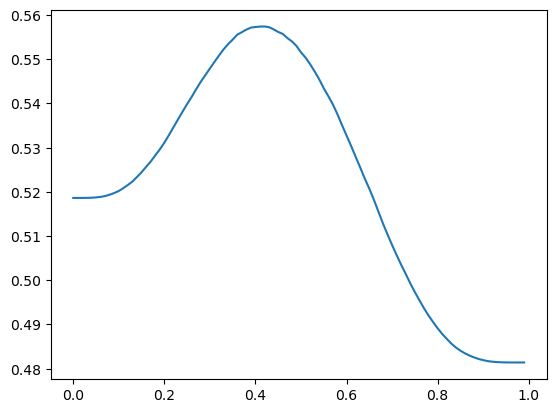

In [14]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,1,0.01), acc)
plt.show()

In [15]:
## evaludation functions

def get_ground_truth(test_output):

    ground_truths = [] 
    df = test_output
    df[['session_position','session_length']] = df[['session_position','session_length']].astype('int64')
    df = df[['session_id','skip_2','session_position','session_length']].loc[df['session_position']*2 > df['session_length']]
    df = df.reset_index()
    current_index = 0
    while current_index < len(df):
        partial_length = df['session_length'].iloc[current_index]-df['session_position'].iloc[current_index]+1
        session_skips = list(df.loc[current_index:current_index+partial_length-1, 'skip_2'])
        ground_truths.append(session_skips)
        current_index += partial_length 
    return ground_truths


def get_submission(test_output):
    submission = []
    for s in test_output['session_id'].unique():
        submission.append(np.array(test_output['pred'][test_output['session_id']==s]*1))
    return submission


def evaluate(submission,groundtruth):
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        if len(sub) != len(tru):
            raise Exception('Line {} should contain {} predictions, but instead contains '
                            '{}'.format(counter+1,len(tru),len(sub)))
        ap_sum += ave_pre(sub,tru,counter)
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc


def ave_pre(submission,groundtruth,counter):
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise Exception('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)

def spotify_eval(y_true, y_pred, input_df):
    df_temp = input_df.loc[y_true.index.values,['session_id','skip_2','session_position','session_length']]
    df_temp['pred'] = y_pred
    ground_truths = get_ground_truth(df_temp)
    submission = get_submission(df_temp)
#     return ground_truths, submission
    ap,first_pred_acc = evaluate(submission,ground_truths)
    return ap,first_pred_acc

In [16]:
s_list = df_lookup['session_id'].unique()[0:10000]
sel_row = df_lookup['session_id'].isin(s_list)

In [34]:
ap,first_pred_acc  = spotify_eval(ytrue[sel_row], ypred[sel_row]>(max_index/100), df_lookup.sort_values(['session_id','session_position']).loc[sel_row])

In [18]:
ap,first_pred_acc  = spotify_eval(ytrue[sel_row], ypred[sel_row]>(max_index/100), df_lookup.loc[sel_row])

In [19]:
# ap,first_pred_acc  = spotify_eval(ytrue, ypred>0.01, df_lookup.sort_values(['session_id','session_position']))

In [35]:
ap

0.4304338042957983

In [36]:
first_pred_acc

0.5755

In [22]:
df_lookup.sort_values(['session_id','session_position'])

,session_id,track_id_clean,skip_2,session_position,session_length,clus,skip_1_sk2True_mean,skip_2_sk2True_mean,skip_3_sk2True_mean,not_skipped_sk2True_mean,...,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,hist_user_behavior_reason_start_clickside_sk2False_mean,hist_user_behavior_reason_start_clickside_sk2True_mean
463004,65_0000b60c-d39c-4554-8371-354729ed60c0,t_51956520-ce7a-4604-9bcb-56bfff7b2736,False,11,20,282,0.714286,1.0,1.0,0.0,...,-0.448360,0.266142,0.200711,-0.102771,-0.552026,0.167256,-0.056987,0.605874,0,0
463045,65_0000b60c-d39c-4554-8371-354729ed60c0,t_25d11783-1ca4-427a-95e6-4f557b2b83c9,True,12,20,251,0.714286,1.0,1.0,0.0,...,-0.309036,0.217209,0.225878,-0.143391,-0.540390,0.220587,0.037699,0.617515,0,0
464069,65_0000b60c-d39c-4554-8371-354729ed60c0,t_ba244873-8564-4ea6-b8bc-d0793b0d0dff,True,13,20,66,0.714286,1.0,1.0,0.0,...,-0.350981,0.286125,0.236305,-0.114115,-0.523562,0.217533,0.099462,0.628256,0,0
464215,65_0000b60c-d39c-4554-8371-354729ed60c0,t_df63af76-311f-4d85-877f-69b356cb5054,True,14,20,172,0.714286,1.0,1.0,0.0,...,-0.346976,0.306263,0.263410,-0.157135,-0.554300,0.240247,0.083986,0.636656,0,0
464234,65_0000b60c-d39c-4554-8371-354729ed60c0,t_8849e9af-6413-4661-9628-f3f503a64f62,True,15,20,109,0.714286,1.0,1.0,0.0,...,-0.313165,0.229884,0.208512,-0.152276,-0.645428,0.243758,0.069302,0.795294,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084986,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_6a18d618-a863-4710-a0f7-edc959e65ad5,False,16,20,69,0.625000,1.0,1.0,0.0,...,0.063448,0.452877,-0.178410,-0.603517,0.177323,0.126411,-0.378101,0.060804,0,0
1137804,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_26e4c895-8d92-4cf7-b6c9-d41861c43f27,False,17,20,287,0.625000,1.0,1.0,0.0,...,0.169253,0.614182,-0.390072,-0.725376,0.397905,0.171512,-0.376916,0.395052,0,0
889714,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_38157f38-9cc5-4248-ac96-60b571e8b37b,False,18,20,188,0.625000,1.0,1.0,0.0,...,0.077334,0.471669,-0.277773,-0.722327,0.294819,0.186959,-0.470139,0.162687,0,0
1081226,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_07074f30-ad55-42f5-a608-e72fd80013b0,False,19,20,129,0.625000,1.0,1.0,0.0,...,0.183129,0.135919,-0.423383,-0.510713,0.689540,0.149603,-0.344343,0.013874,0,0


In [23]:
len(df_lookup['skip_2'][sel_row])

84622

In [24]:
# import shap

# # print the JS visualization code to the notebook
# shap.initjs()

In [25]:
# bst.feature_name()

In [26]:
# bst.params['objective'] = 'binary'
# bst.params

In [27]:
# explainer = shap.TreeExplainer(bst)

In [28]:
# start = timer()
# shap_values = explainer.shap_values(df_test)
# print('Runtime per batch: %0.2fs' % (timer() - start))

In [29]:
# len(shap_values)

In [30]:
# shap.summary_plot(shap_values[0], df_test, max_display = 40, plot_size = (15,10), show=False)
# plt.savefig('../models/SVD/LightGBM_BayesOpt_dec17/for20180918/SHAPsummary0_boost_alltracks_incrementalTrain_10_dec23.png')
# plt.show()

In [31]:
# shap.summary_plot(shap_values[1], df_test, max_display = 40, plot_size = (15,10), show=False)
# plt.savefig('../models/SVD/LightGBM_BayesOpt_dec17/for20180918/SHAPsummary1_boost_alltracks_incrementalTrain_10_dec23.png')
# plt.show()

In [32]:
# shap.dependence_plot(ind = 'session_position', shap_values=shap_values[0], features=df_test, show=False)
# plt.savefig("my_dependence_plot.pdf")
# plt.show()

In [33]:
# shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], df_test.iloc[:1000,:])